In [1]:
# !pip install pandas
# !pip install scikit-learn
# !pip show tensorflow

**Check if TensorFlow is built with CUDA (GPU) support**

In [2]:
import tensorflow as tf

print("Built with CUDA:", tf.test.is_built_with_cuda())

# listing the available devices
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
for device in physical_devices:
    print(device)

2024-06-12 08:58:47.079102: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 08:58:47.079172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 08:58:47.080206: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-12 08:58:47.088005: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 08:58:48.064750: W tensorflow/compiler/tf2

Built with CUDA: True
Num GPUs Available:  3
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')


In [3]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


2024-06-12 08:58:49.570853: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43339 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6
2024-06-12 08:58:49.573177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43339 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:61:00.0, compute capability: 8.6
2024-06-12 08:58:49.575012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 43339 MB memory:  -> device: 2, name: NVIDIA A40, pci bus id: 0000:a1:00.0, compute capability: 8.6


Number of devices: 3


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from sklearn.metrics import classification_report, roc_auc_score
import os
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array

In [5]:
import os

print(os.getcwd())

/home/adrian/catalina.chirtes/CNN models/CNN_3epochs_category


**Read dataset**

In [6]:
filtered_clothing = pd.read_csv('../../filtered_clothing_dataset.csv')

**Split dataset in training and testing set**

In [7]:
eighty_pct = int(0.8*len(filtered_clothing))
  
train_set = filtered_clothing.iloc[:(eighty_pct-1), :] 
test_set = filtered_clothing.iloc[eighty_pct:, :] 
  
train_set.to_csv("train_data.csv", index=False)
test_set.to_csv("test_data.csv", index=False)

**Loading the dataset**

In [8]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [9]:
# image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

# data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data['id'] = train_data['id'].astype(str) + '.jpg'
test_data['id'] = test_data['id'].astype(str) + '.jpg'

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='../../filtered_images',
    x_col="id",
    y_col="subCategory",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True) 

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='../../filtered_images',
    x_col="id",
    y_col="subCategory",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 22344 validated image filenames belonging to 5 classes.
Found 5587 validated image filenames belonging to 5 classes.


**Defining the CNN model**

In [10]:
input_shape = (img_width, img_height, 3)
input_layer = Input(shape=input_shape)
with strategy.scope():
    model = Sequential([
        input_layer,
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(5, activation='softmax')  # 5 categories in the dataset
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

**Model training**

In [11]:
# number of training and validation steps
train_steps_per_epoch = len(train_data) // batch_size
test_steps_per_epoch = len(test_data) // batch_size

with strategy.scope():
# model training
    history = model.fit(
        train_generator,
        steps_per_epoch=train_steps_per_epoch,
        epochs=3,
        validation_data=test_generator,
        validation_steps=test_steps_per_epoch)

Epoch 1/3
INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/re

2024-06-12 08:58:57.958835: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-12 08:58:57.980076: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-12 08:58:57.994702: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-12 08:59:01.035911: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8084d4bea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-12 08:59:01.035966: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-06-12 08:59:01.035976: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A40, Compute Capability 8.6
2024-06-12 08:59:01.035984: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A40, Compute Capability 8.6
2024-06-12 08:59:01.046147: I tens

698/698 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.9402INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
698/698 [==============================] - 280s 389ms/step - loss: 0.1918 - accuracy: 0.9402 - val_loss: 0.0851 - val_accuracy: 0.9781
Epoch 2/3
698/698 [==============================] - 274s 393ms/step - loss: 0.0922 - accuracy: 0.9733 - val_loss: 0.0695 - val_accuracy: 0.9802
Epoch 3/3
698/698 [==============================] - 267s 382ms/step - loss: 0.0618 - accuracy: 0.9799 - val_loss: 0.0628 - val_accuracy: 0.9846


**Save model**

In [12]:
model.save('CNN_model_12062024_3epochs_gpu.keras')
print("Saving the model as CNN_model_12062024_3epochs_gpu.keras")

Saving the model as CNN_model_12062024_3epochs_gpu.keras


**Model evaluation**

In [13]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# predicting the probabilities for the test set
y_pred_proba = model.predict(test_generator)

# converting the probabilities to class predictions
y_pred = np.argmax(y_pred_proba, axis=1)

# getting the true labels
y_true = test_generator.classes

# computing the precision, recall, f1-score, support
print("Classification Report:")
print(classification_report(y_true, y_pred))

# computing the AUC-ROC score with the multi_class='ovr'
auc_roc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
print("AUC-ROC Score (ovr):", auc_roc)

# computing the AUC-ROC score with the multi_class='ovo'
auc_roc_ovo = roc_auc_score(y_true, y_pred_proba, multi_class='ovo')
print("AUC-ROC Score (ovo):", auc_roc_ovo)

174/174 [==============================] - 7s 37ms/step - loss: 0.0628 - accuracy: 0.9846
Test Loss: 0.06275951117277145
Test Accuracy: 0.9845545887947083
175/175 [==============================] - 7s 31ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       553
           1       0.97      0.98      0.97       489
           2       0.81      0.71      0.76        79
           3       1.00      1.00      1.00      1875
           4       0.99      0.99      0.99      2591

    accuracy                           0.98      5587
   macro avg       0.94      0.93      0.94      5587
weighted avg       0.98      0.98      0.98      5587

AUC-ROC Score (ovr): 0.9971764089618163
AUC-ROC Score (ovo): 0.9963805768643746


**Accuracy per subcategory**

175/175 [==============================] - 6s 32ms/step
Accuracy for subcategory 'Bags': 0.9855334538878843
Accuracy for subcategory 'Bottomwear': 0.9775051124744376
Accuracy for subcategory 'Dress': 0.7088607594936709
Accuracy for subcategory 'Shoes': 0.9957333333333334
Accuracy for subcategory 'Topwear': 0.986105750675415


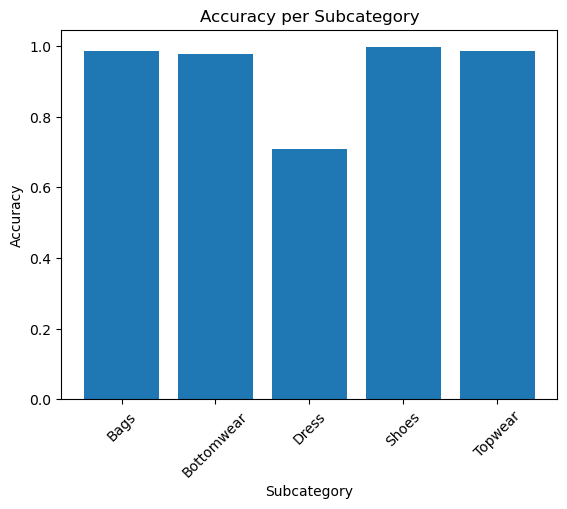

In [14]:
# converting the class_labels to a list
class_labels = list(train_generator.class_indices.keys())

# predicting the probabilities for the test set
predictions = model.predict(test_generator)

# getting the the predicted labels for each image
predicted_labels = [class_labels[i] for i in np.argmax(predictions, axis=1)]

# getting the true labels for each image
true_labels = [class_labels[i] for i in test_generator.classes]

# initializing a dictionary to store the counts of the correct predictions and the total counts for each subcategory
subcategory_counts = {class_label: [0, 0] for class_label in class_labels}

# iterating through each prediction and updating the counts
for true_label, predicted_label in zip(true_labels, predicted_labels):
    subcategory_counts[true_label][1] += 1
    if true_label == predicted_label:
        subcategory_counts[true_label][0] += 1

# computing the accuracy for each subcategory
subcategory_accuracies = {class_label: (count[0] / count[1]) if count[1] != 0 else 0 for class_label, count in subcategory_counts.items()}

# displaying the accuracy per subcategory
for class_label, accuracy in subcategory_accuracies.items():
    print(f"Accuracy for subcategory '{class_label}': {accuracy}")

# plotting the accuracy per subcategory
plt.bar(subcategory_accuracies.keys(), subcategory_accuracies.values())
plt.xlabel('Subcategory')
plt.ylabel('Accuracy')
plt.title('Accuracy per Subcategory')
plt.xticks(rotation=45)
plt.show()


**Saving the History Object**

In [26]:
import pickle

with open('history_12062024_3epochs.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

AttributeError: 'dict' object has no attribute 'history'

**Plotting the history**

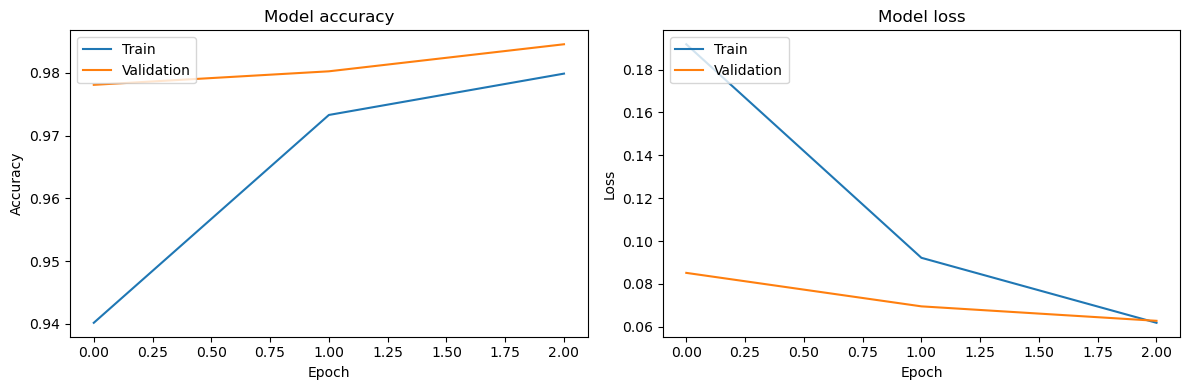

In [24]:
# loading the history object
with open('history_12062024_3epochs.pkl', 'rb') as file_pi:
    history = pickle.load(file_pi)

# plotting the training & validation accuracy and the loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Predict the label and accuracy of an external image**

1/1 [==============================] - 1s 956ms/step


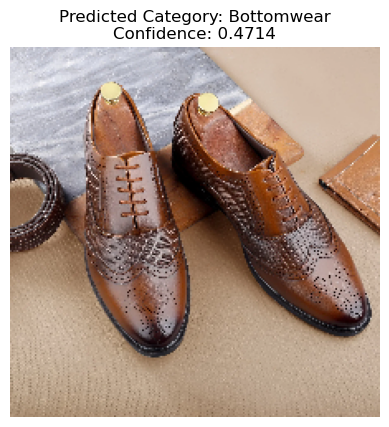

1/1 [==============================] - 0s 247ms/step


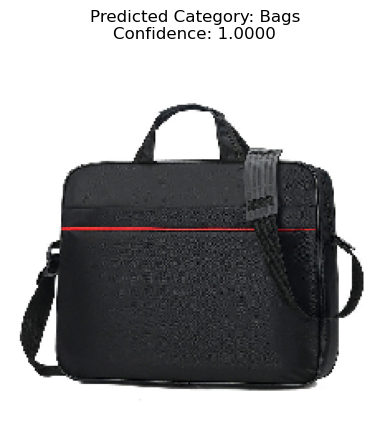

1/1 [==============================] - 0s 228ms/step


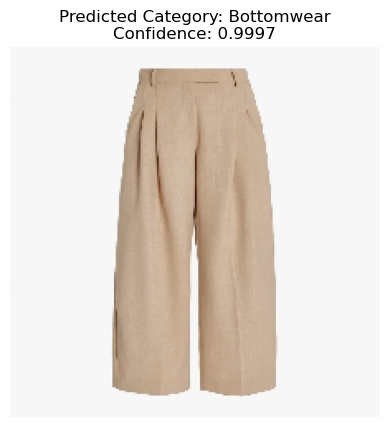

1/1 [==============================] - 0s 208ms/step


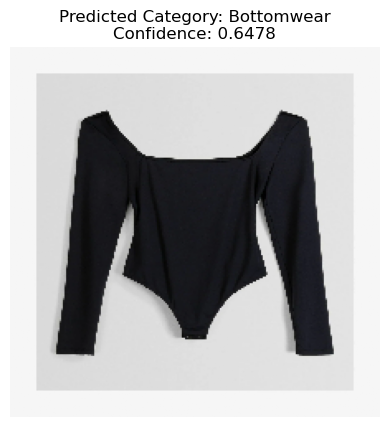

1/1 [==============================] - 0s 201ms/step


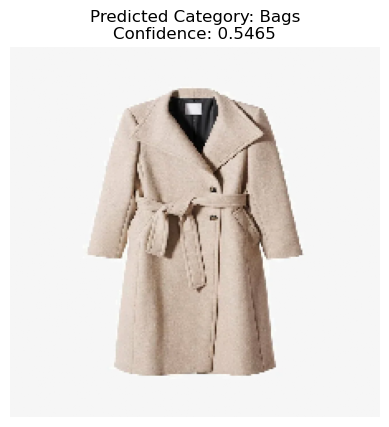

1/1 [==============================] - 0s 185ms/step


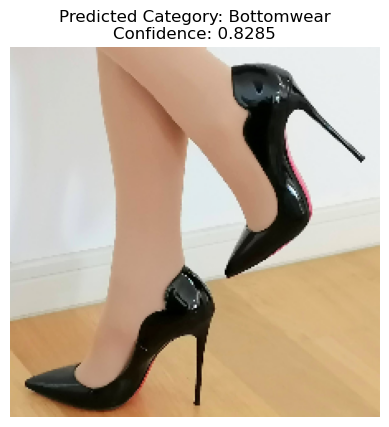

1/1 [==============================] - 0s 185ms/step


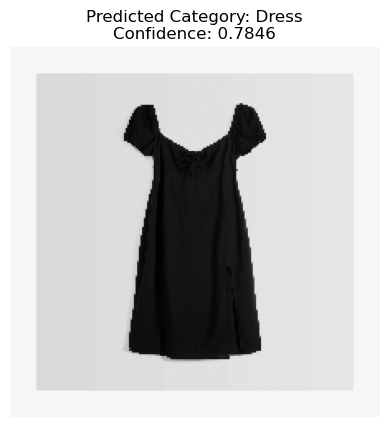

1/1 [==============================] - 0s 183ms/step


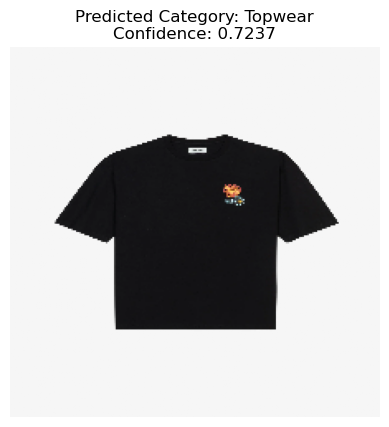

1/1 [==============================] - 0s 180ms/step


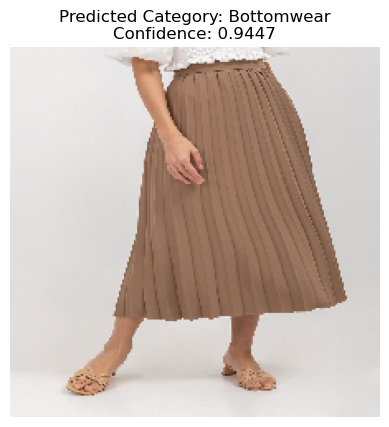

1/1 [==============================] - 0s 182ms/step


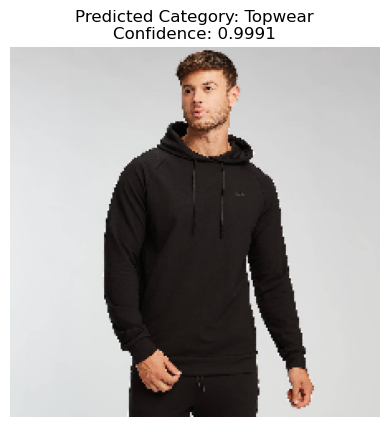

1/1 [==============================] - 0s 182ms/step


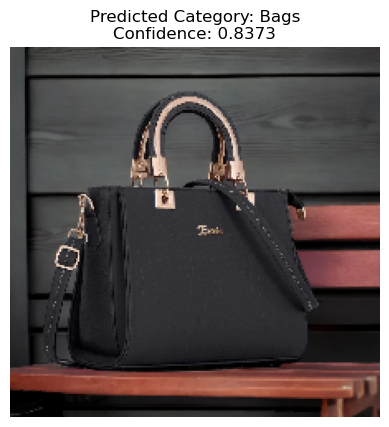

1/1 [==============================] - 0s 194ms/step


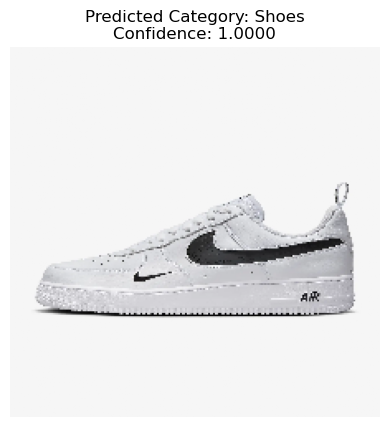

1/1 [==============================] - 0s 184ms/step


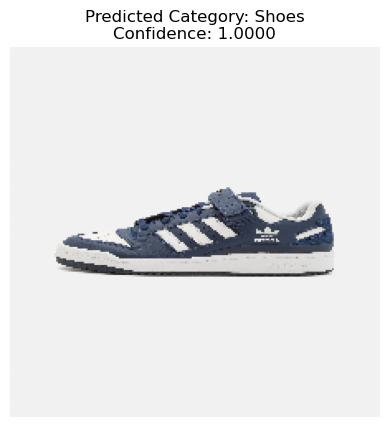

1/1 [==============================] - 0s 185ms/step


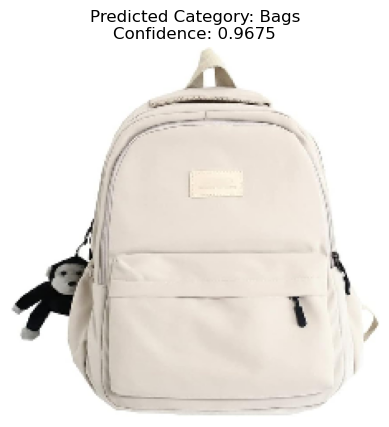

1/1 [==============================] - 0s 185ms/step


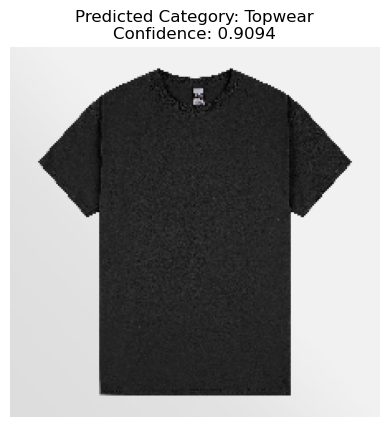

1/1 [==============================] - 0s 182ms/step


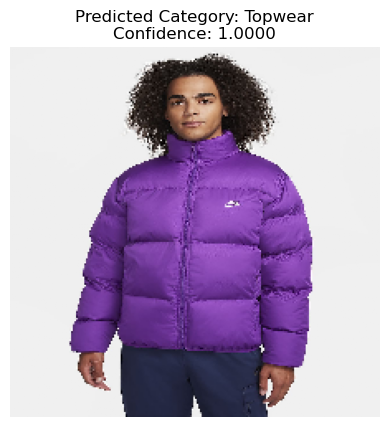

1/1 [==============================] - 0s 185ms/step


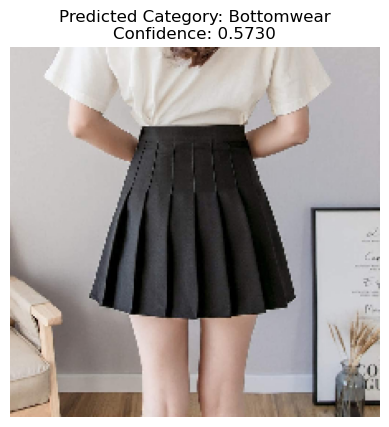

1/1 [==============================] - 0s 236ms/step


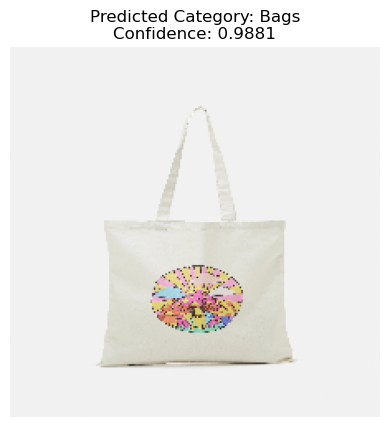

1/1 [==============================] - 0s 309ms/step


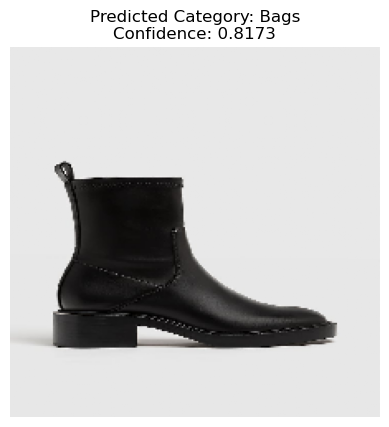

1/1 [==============================] - 0s 299ms/step


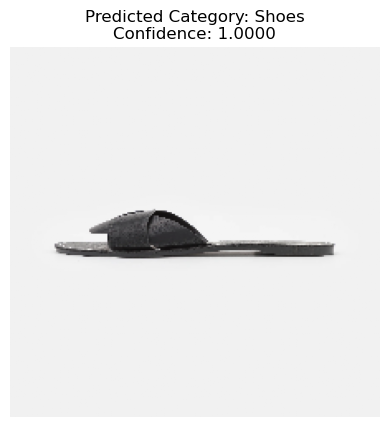

1/1 [==============================] - 0s 297ms/step


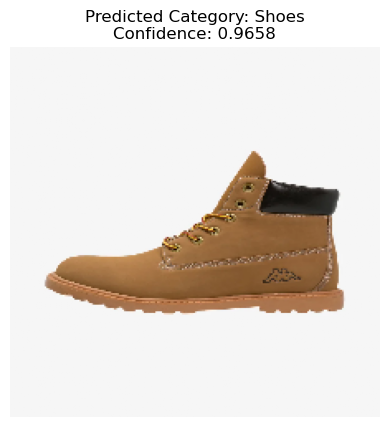

1/1 [==============================] - 0s 264ms/step


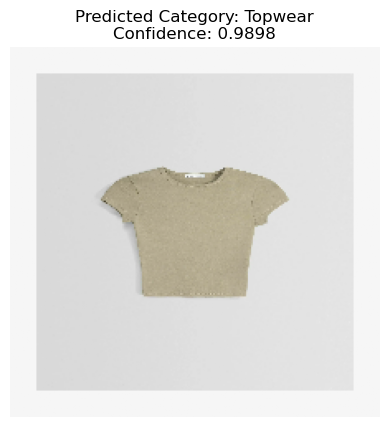

1/1 [==============================] - 0s 219ms/step


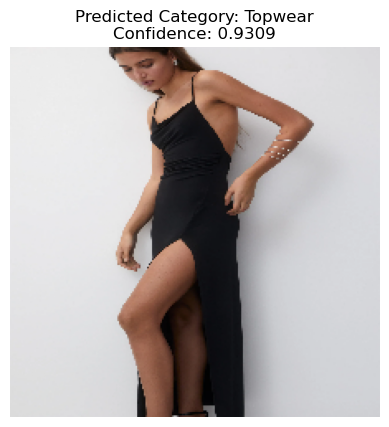

1/1 [==============================] - 0s 192ms/step


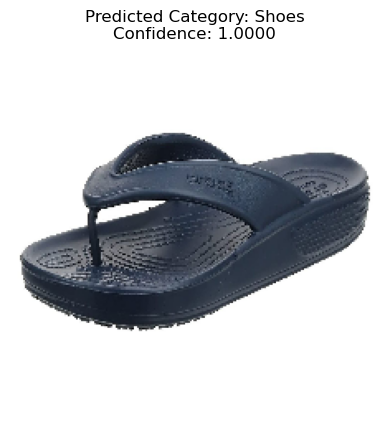

1/1 [==============================] - 0s 183ms/step


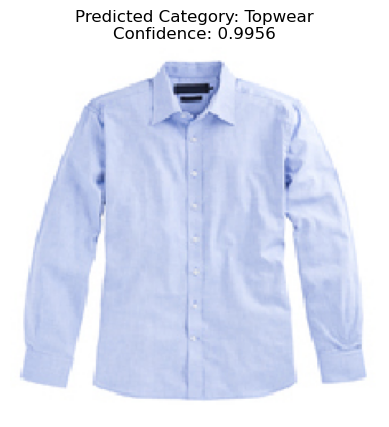

1/1 [==============================] - 0s 231ms/step


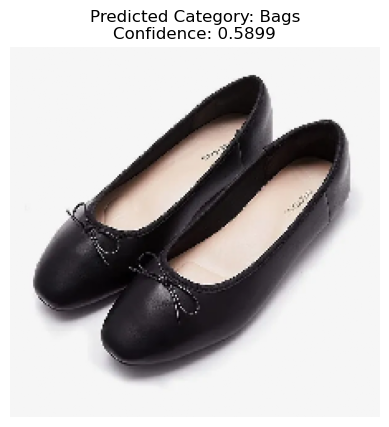

1/1 [==============================] - 0s 301ms/step


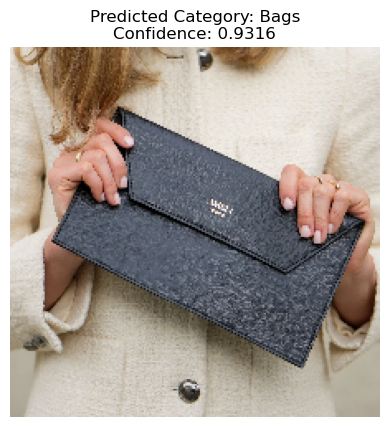

1/1 [==============================] - 0s 297ms/step


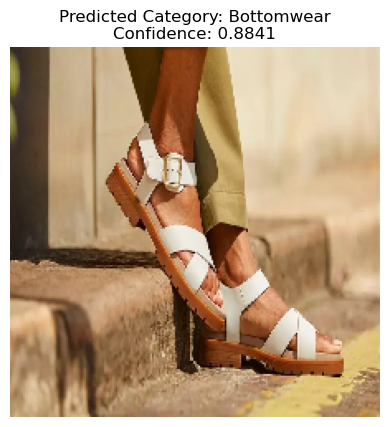

1/1 [==============================] - 0s 293ms/step


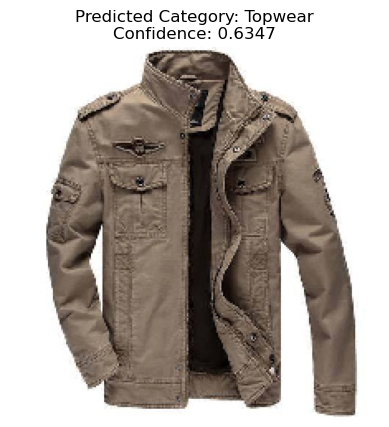

1/1 [==============================] - 0s 248ms/step


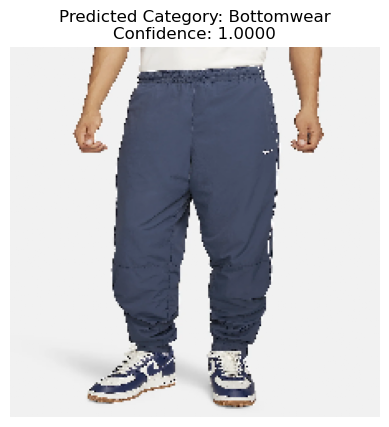

1/1 [==============================] - 0s 215ms/step


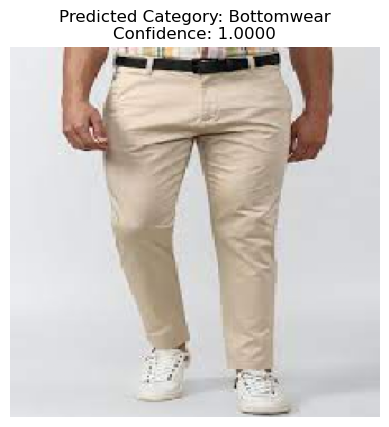

1/1 [==============================] - 0s 191ms/step


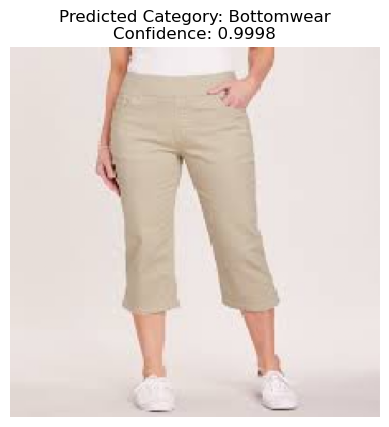

1/1 [==============================] - 0s 196ms/step


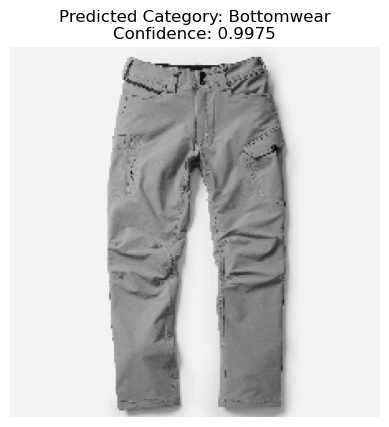

1/1 [==============================] - 0s 185ms/step


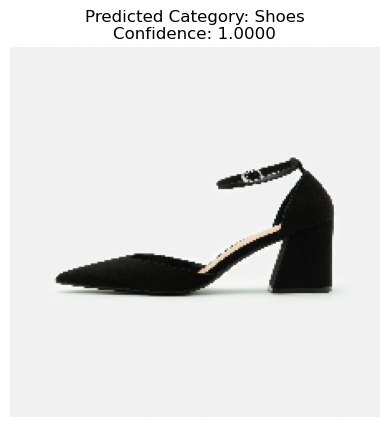

1/1 [==============================] - 0s 183ms/step


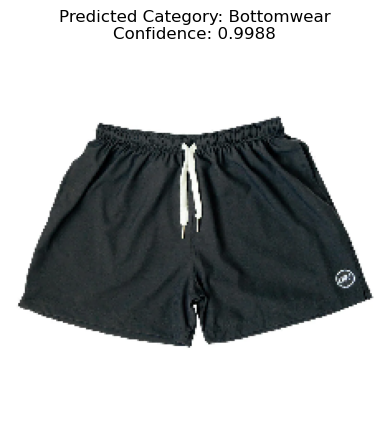

In [15]:
# function to make predictions with dynamically generated category labels
def predict_image_category_with_dynamic_labels(image_path, model, train_generator):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)

    # getting the index of the class with the highest probability
    predicted_class = np.argmax(predictions[0])  
    
    # generating a mapping of the class indices to the category labels
    class_labels = {i: label for i, label in enumerate(train_generator.class_indices.keys())}

    # getting the corresponding label using the class index
    predicted_label = class_labels[predicted_class] 

    # computing the confidence score of the prediction
    confidence = predictions[0][predicted_class]  
    
    return predicted_label, confidence, img_array

def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0 
    return img_array

def parse_images_in_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.webp', '.hpg', '.png'))]
    images_data = []
    for file in image_files:
        image_path = os.path.join(folder_path, file)
        preprocessed_image = preprocess_image(image_path)
        images_data.append((image_path, preprocessed_image)) 
    return images_data


images_folder_path = '../../clothing_test_dataset/'

images_data = parse_images_in_folder(images_folder_path)

for image_path, preprocessed_image in images_data:
    # predicting the category and the confidence for the image
    predicted_label, confidence, img_array = predict_image_category_with_dynamic_labels(image_path, model, train_generator)
    
    # displaying the image along with the predicted category and confidence
    plt.imshow(img_array[0])
    plt.title(f'Predicted Category: {predicted_label}\nConfidence: {confidence:.4f}')
    plt.axis('off')
    plt.show()
